In [1]:
from __future__ import annotations

from functools import partial

import polars
import torch
import pytorch_lightning as pl
from tqdm import tqdm

from mts_ml_cup.utils import polars_map
from mts_ml_cup.preprocessing import urls as u

/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
df = polars.read_parquet("../data/processed/sessions.pq")

CPU times: user 59.1 s, sys: 15.3 s, total: 1min 14s
Wall time: 28.2 s


# Data preparation

In [3]:
%%time
url_cleaner = partial(
    u.clean_url,
    preprocessors=[
        u.decode_from_punycode,
        u.lower,
        u.replace_hyphens_with_dots,
    ],
)
urls_mapping = (
    df
    .select("url_host")
    .unique()
    .with_columns(polars.col("url_host").apply(url_cleaner).alias("url_cleaned"))
    .with_columns(polars.col("url_cleaned").rank(method="dense").alias("url_id"))
    .select(["url_host", "url_id"])
    .to_pandas()
    .set_index("url_host")["url_id"]
    .to_dict()
)

dates = df["date"].unique()
dates_mapping = dict(zip(sorted(dates), range(1, len(dates) + 1)))

df = (
    df
    .join(
        other=polars_map(
            mapping=urls_mapping,
            key_name="url_host",
            id_name="url_id",
            id_dtype=polars.UInt32,
        ),
        how="left",
        on="url_host",
    )
    .join(
        other=polars_map(
            mapping=dates_mapping,
            key_name="date",
            id_name="date_id",
            id_dtype=polars.UInt16,
        ),
        how="left",
        on="date",
    )
)

CPU times: user 1min 39s, sys: 26.2 s, total: 2min 5s
Wall time: 32.6 s


In [18]:
torch.tensor(range(10), dtype=torch.int32)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)

In [6]:
seqlen = df["user_id"].value_counts()["counts"]

In [9]:
seqlen.describe()

statistic,value
str,f64
"""min""",1.0
"""max""",29596.0
"""null_count""",0.0
"""mean""",777.477048
"""std""",1034.880997
"""count""",415317.0


<Axes: ylabel='Frequency'>

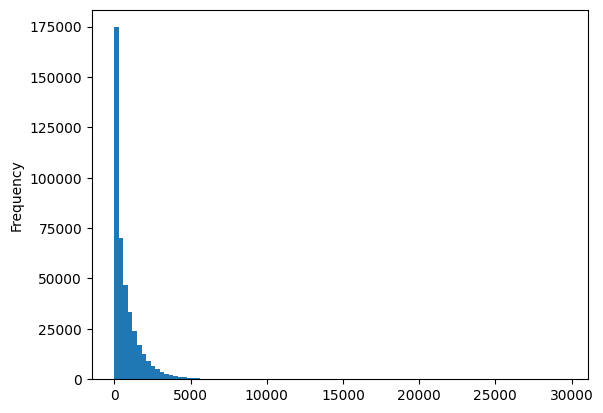

In [12]:
seqlen.to_pandas().plot.hist(bins=100)

In [13]:
for q in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    print(q, seqlen.quantile(q))

0.1 21.0
0.2 68.0
0.3 151.0
0.4 268.0
0.5 421.0
0.6 617.0
0.7 883.0
0.8 1269.0
0.9 1962.0


In [19]:
print(
    f"{df['region_id'].n_unique() = }\n"
    f"{df['city_id'].n_unique() = }\n"
    
    f"{df['manufacturer_id'].n_unique() = }\n"
    f"{df['model_id'].n_unique() = }\n"
    f"{df['type_id'].n_unique() = }\n"
    f"{df['os_id'].n_unique() = }\n"
    
    f"{df['date_id'].n_unique() = }\n"
    f"{df['part_of_day_id'].n_unique() = }\n"
    f"{df['url_id'].n_unique() = }"
)

df['region_id'].n_unique() = 81
df['city_id'].n_unique() = 1000
df['manufacturer_id'].n_unique() = 31
df['model_id'].n_unique() = 603
df['type_id'].n_unique() = 4
df['os_id'].n_unique() = 2
df['date_id'].n_unique() = 396
df['part_of_day_id'].n_unique() = 4
df['url_id'].n_unique() = 199508


In [20]:
def dataset_for_ptls(df: polars.DataFrame) -> dict[str, torch.Tensor]:
    dataset = []
    for user_id, user_df in tqdm(df.groupby("user_id"), total=df["user_id"].n_unique()):
        user_df = user_df.sort(["date", "part_of_day_id"])
        user_encoded = {
            "user_id": user_id,
            "region_id": torch.from_numpy(user_df["region_id"].to_numpy()),
            
            "city_id": torch.from_numpy(user_df["city_id"].to_numpy().astype("int16")),
            "manufacturer_id": torch.from_numpy(user_df["manufacturer_id"].to_numpy()),
            "model_id": torch.from_numpy(user_df["model_id"].to_numpy().astype("int16")),
            "type_id": torch.from_numpy(user_df["type_id"].to_numpy()),
            "os_id": torch.from_numpy(user_df["os_id"].to_numpy()),
            
            "event_time": torch.tensor(range(1, len(user_df) + 1)),
            "date_id": torch.from_numpy(user_df["date_id"].to_numpy().astype("int16")),
            "part_of_day_id": torch.from_numpy(user_df["part_of_day_id"].to_numpy()),
            "url_id": torch.from_numpy(user_df["url_id"].to_numpy().astype("int32")),
            "request_cnt": torch.from_numpy(user_df["request_cnt"].to_numpy()),
        }
        dataset.append(user_encoded)
    return dataset

In [21]:
dataset = dataset_for_ptls(df)

  0%|                                                | 0/415317 [00:00<?, ?it/s]/tmp/ipykernel_956018/824887297.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  "region_id": torch.from_numpy(user_df["region_id"].to_numpy()),
100%|██████████████████████████████████| 415317/415317 [08:08<00:00, 851.01it/s]


In [22]:
%%time
torch.save(dataset, "../data/ptls-v3/dataset.pt")

CPU times: user 3min 15s, sys: 13.9 s, total: 3min 29s
Wall time: 3min 34s


In [25]:
%%time
torch.save(dataset[:10_000], "../data/ptls-v3/dataset-sample.pt")

CPU times: user 3.88 s, sys: 305 ms, total: 4.19 s
Wall time: 5.03 s


In [26]:
! ls -lh ../data/ptls-v3/

total 8.6G
-rw-rw-r-- 1 ababkin ababkin 8.4G Mar 22 16:34 dataset.pt
-rw-rw-r-- 1 ababkin ababkin 200M Mar 22 17:10 dataset-sample.pt


# Fit self-supervised

In [2]:
%%time
dataset = torch.load("../data/ptls-v3/dataset.pt")

CPU times: user 2min 45s, sys: 15.6 s, total: 3min 1s
Wall time: 3min 1s


In [3]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

In [4]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(
        embeddings={
            "region_id": {"in": 81, "out": 4},
            "city_id": {"in": 1_000, "out": 8},
            
            "manufacturer_id": {"in": 31, "out": 4},
            "model_id": {"in": 603, "out": 8},
            "type_id": {"in": 4, "out": 1},
            "os_id": {"in": 2, "out": 1},
            
            "date_id": {"in": 396, "out": 8},
            "part_of_day_id": {"in": 4, "out": 2},
            "url_id": {"in": 199508, "out": 128},
        },
        embeddings_noise=0.003,
        numeric_values={
            "request_cnt": "log",
        },
        use_batch_norm_with_lens=True,
        orthogonal_init=True,
    ),
    hidden_size=256,
    type="gru",
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(
        torch.optim.lr_scheduler.OneCycleLR,
        max_lr=1e-3,
        total_steps=146_800, epochs=100, steps_per_epoch=1468,
        pct_start=0.3, anneal_strategy="cos",
        cycle_momentum=True, base_momentum=0.85, max_momentum=0.95,
        div_factor=25.0, final_div_factor=10_000.0, three_phase=False,
        last_epoch=-1, verbose=False,
    ),
)

In [5]:
sum(p.numel() for p in seq_encoder.parameters())

25878600

In [6]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices, SampleRandom
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        MemoryMapDataset(
            data=dataset,
            i_filters=[
                SeqLenFilter(min_seq_len=20)
            ]
        ),
        splitter=SampleRandom(
            split_count=5,
            cnt_min=100,
            cnt_max=300,
        ),
    ),
    train_num_workers=0,
    train_batch_size=256,
)

In [7]:
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 25.9 M
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
25.9 M    Trainable params
0         Non-trainable params
25.9 M    Total params
103.514   Total estimated model params size (MB)
/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/pytorch_lightning/tr

Epoch 15:  88%|▉| 1296/1468 [10:14<01:21,  2.11it/s, loss=10, v_num=27, seq_len=

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 18:  38%|▍| 560/1468 [04:27<07:13,  2.09it/s, loss=8.76, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 20:  77%|▊| 1133/1468 [08:55<02:38,  2.12it/s, loss=8.19, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 23:  28%|▎| 407/1468 [03:13<08:24,  2.11it/s, loss=8.52, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 25:  79%|▊| 1166/1468 [09:11<02:22,  2.12it/s, loss=9.67, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 28:  15%|▏| 218/1468 [01:43<09:52,  2.11it/s, loss=6.92, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 30:  62%|▌| 909/1468 [07:09<04:23,  2.12it/s, loss=9.32, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 33:   7%| | 102/1468 [00:50<11:20,  2.01it/s, loss=6.29, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 35:  49%|▍| 724/1468 [05:41<05:50,  2.12it/s, loss=7.47, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 37:  80%|▊| 1179/1468 [09:20<02:17,  2.10it/s, loss=6.7, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 40:  20%|▏| 299/1468 [02:20<09:08,  2.13it/s, loss=7.3, v_num=27, seq_len=

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 42:  65%|▋| 957/1468 [07:36<04:03,  2.10it/s, loss=7.06, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 45:  10%| | 150/1468 [01:08<09:58,  2.20it/s, loss=6.51, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 47:  18%|▏| 271/1468 [02:07<09:23,  2.13it/s, loss=5.94, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 47:  54%|▌| 800/1468 [06:20<05:17,  2.10it/s, loss=6.15, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 55:  80%|▊| 1168/1468 [09:11<02:21,  2.12it/s, loss=6.72, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 58:  30%|▎| 446/1468 [03:34<08:10,  2.08it/s, loss=7.21, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 60:  74%|▋| 1091/1468 [08:36<02:58,  2.11it/s, loss=6.33, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 63:  22%|▏| 319/1468 [02:33<09:13,  2.08it/s, loss=6.52, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 82:  80%|▊| 1175/1468 [09:18<02:19,  2.10it/s, loss=4.94, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 85:  26%|▎| 387/1468 [03:04<08:34,  2.10it/s, loss=6.82, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 87:  38%|▍| 559/1468 [04:27<07:14,  2.09it/s, loss=6.18, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 89:  90%|▉| 1326/1468 [10:32<01:07,  2.09it/s, loss=5.91, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 91:  92%|▉| 1346/1468 [10:37<00:57,  2.11it/s, loss=6.03, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 94:  37%|▎| 544/1468 [04:21<07:23,  2.08it/s, loss=6.72, v_num=27, seq_len

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 96:  86%|▊| 1267/1468 [10:02<01:35,  2.10it/s, loss=5.82, v_num=27, seq_le

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 99: 100%|█| 1468/1468 [11:39<00:00,  2.10it/s, loss=5.3, v_num=27, seq_len
{'loss': tensor(0.3499), 'seq_len': tensor(164.6765)}


In [9]:
print(trainer.logged_metrics)

{'loss': tensor(0.3499), 'seq_len': tensor(164.6765)}


In [10]:
%%time
torch.save(seq_encoder, "../data/ptls-v3/seq-encoder.pt")

CPU times: user 41.3 ms, sys: 80.2 ms, total: 121 ms
Wall time: 120 ms


In [11]:
%%time
torch.save(model, "../data/ptls-v3/model.pt")

CPU times: user 3min 7s, sys: 15.8 s, total: 3min 23s
Wall time: 3min 28s


In [12]:
from ptls.data_load.datasets import inference_data_loader

In [13]:
inference_dl = inference_data_loader(dataset, num_workers=0, batch_size=256)

In [14]:
model.eval();

In [15]:
%%time
coles_embs = torch.vstack(trainer.predict(model, inference_dl))
coles_embs.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: : 0it [00:00, -1501765.43it/s]

/home/ababkin/.cache/pypoetry/virtualenvs/mts-ml-cup-qFoUb2su-py3.8/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: : 1623it [07:51,  3.04s/it]   
CPU times: user 7min 59s, sys: 1min 16s, total: 9min 16s
Wall time: 7min 52s


torch.Size([415317, 256])

In [16]:
torch.save(coles_embs, "../data/ptls-v3/embeddings.pt")

In [17]:
user_ids = [d["user_id"] for d in dataset]

In [18]:
import joblib as jbl
jbl.dump(user_ids, "../data/ptls-v3/user_ids-long.jbl")

['../data/ptls-v3/user_ids-long.jbl']

In [19]:
%%time
import pandas as pd
embs = pd.DataFrame()
embs["user_id"] = user_ids
embs["ptls_embeddings"] = pd.DataFrame(coles_embs.numpy()).apply(lambda x: x.tolist(), axis=1)
embs = (
    polars.from_pandas(embs)
    .with_columns(polars.col("ptls_embeddings").cast(polars.List(polars.Float32)))
)

CPU times: user 11.3 s, sys: 2.15 s, total: 13.5 s
Wall time: 13.5 s


In [20]:
embs.write_parquet("../data/features/ptls/embs-long.pq")